# Paquetes necesarios y ruta de archivos

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import zipfile
import cv2
from skimage import io
import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from tensorflow.keras import backend as K
from sklearn.preprocessing import StandardScaler, normalize
import os
import glob
import random
from google.colab import files
%matplotlib inline

In [ ]:
# Montar directorio de trabajo del drive
%cd /content/drive/MyDrive/Data_MRI/

/content/drive/MyDrive/Data_MRI


In [ ]:
# Leer archivo CSV que contiene la ruta de cada MRI junto con su máscara, obtenidos de Kaggle
brain_df = pd.read_csv('data_mask.csv')
brain_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   patient_id  3929 non-null   object
 1   image_path  3929 non-null   object
 2   mask_path   3929 non-null   object
 3   mask        3929 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 122.9+ KB


In [ ]:
# Mostrar los primeros registros
brain_df.head(20)

patient_id  ... mask
0   TCGA_CS_5395_19981004  ...    0
1   TCGA_CS_5395_19981004  ...    0
2   TCGA_CS_5395_19981004  ...    0
3   TCGA_CS_5395_19981004  ...    0
4   TCGA_CS_5395_19981004  ...    0
5   TCGA_CS_5395_19981004  ...    0
6   TCGA_CS_5395_19981004  ...    0
7   TCGA_CS_5395_19981004  ...    0
8   TCGA_CS_5395_19981004  ...    0
9   TCGA_CS_5395_19981004  ...    0
10  TCGA_CS_5395_19981004  ...    0
11  TCGA_CS_5395_19981004  ...    0
12  TCGA_CS_5395_19981004  ...    0
13  TCGA_CS_5395_19981004  ...    0
14  TCGA_CS_5395_19981004  ...    0
15  TCGA_CS_5395_19981004  ...    0
16  TCGA_CS_5395_19981004  ...    0
17  TCGA_CS_5395_19981004  ...    0
18  TCGA_CS_5395_19981004  ...    0
19  TCGA_CS_5395_19981004  ...    0

[20 rows x 4 columns]

In [ ]:
# Ruta a la máscara de segmentación
brain_df.mask_path[1]

'TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1_mask.tif'

In [ ]:
# Ruta a la imagen MRI
brain_df.image_path[1]

'TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1.tif'

# Visualización de los datos

In [ ]:
# Se utiliza Plotly para hacer un diagrama de barras
import plotly.graph_objects as go
fig = go.Figure([go.Bar(x = brain_df['mask'].value_counts().index, y = brain_df['mask'].value_counts())])
fig.update_traces(marker_color = 'rgb(200,0,0)', marker_line_color ='rgb(255,0,0)',
                  marker_line_width = 7, opacity = 0.6)
fig.show()

In [ ]:
# Mostrar todas las rutas de la máscara de segmentación
brain_df.mask_path

0       TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1_...
1       TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1_...
2       TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1_...
3       TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1_...
4       TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1_...
                              ...                        
3924    TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_86...
3925    TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_87...
3926    TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_87...
3927    TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_88...
3928    TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_88...
Name: mask_path, Length: 3929, dtype: object

In [ ]:
# Mostrar todas las rutas de las imagenes MRI
brain_df.image_path

0       TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1.tif
1       TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1.tif
2       TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1.tif
3       TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1.tif
4       TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1.tif
                              ...                        
3924    TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_86...
3925    TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_87...
3926    TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_87...
3927    TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_88...
3928    TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_88...
Name: image_path, Length: 3929, dtype: object

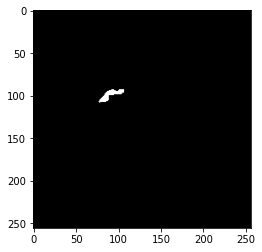

In [ ]:
# Visualizar máscara
plt.imshow(cv2.imread(brain_df.mask_path[623]))

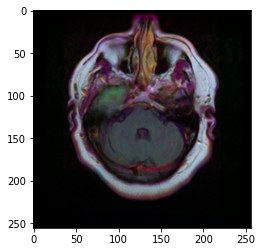

In [ ]:
# Visualizar imagen MRI
plt.imshow(cv2.imread(brain_df.image_path[623]))

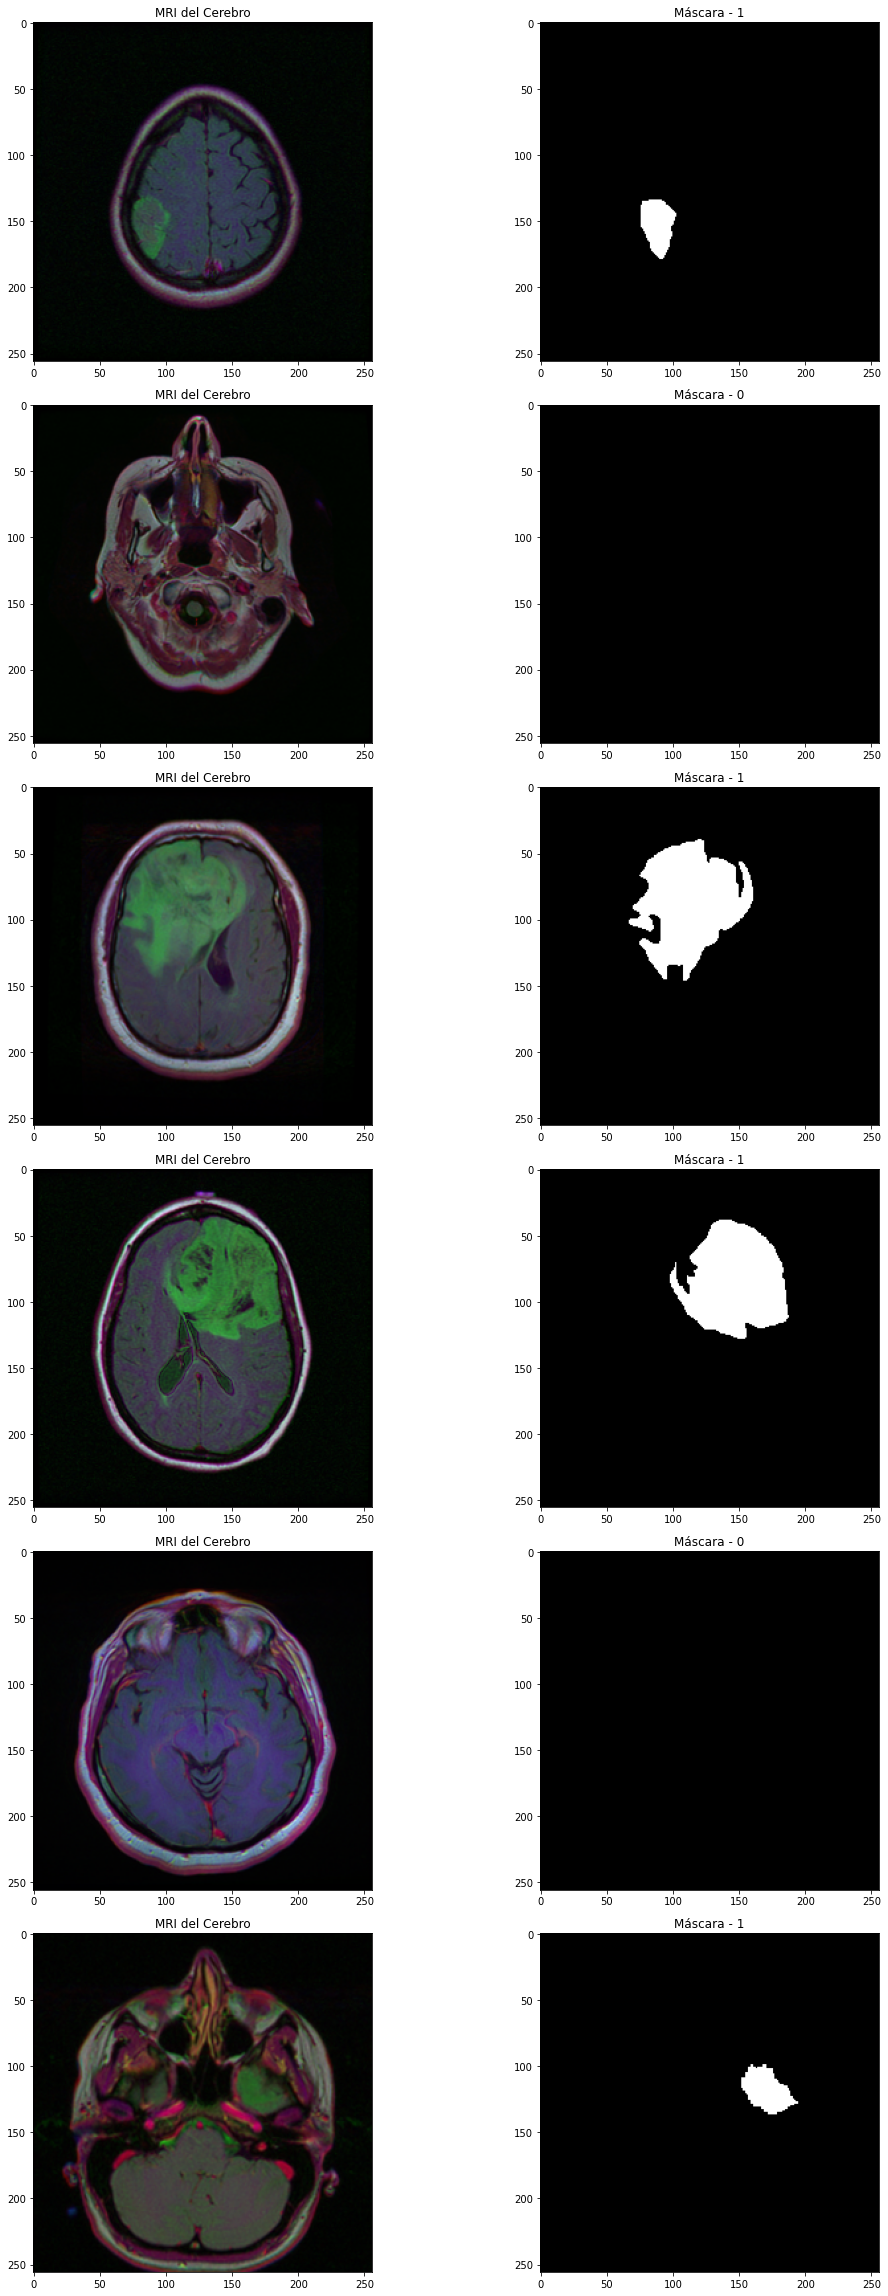

In [ ]:
# Visualizar img (MRI & mask) en el dataset de forma separada
import random
fig, axs = plt.subplots(6,2, figsize=(16, 32))
count = 0
for x in range(6):
  i = random.randint(0, len(brain_df)) # Indice aleatorio
  axs[count][0].title.set_text('MRI del Cerebro') # Texto del título
  axs[count][0].imshow(cv2.imread(brain_df.image_path[i])) # Mostrar MRI
  axs[count][1].title.set_text('Máscara - ' + str(brain_df['mask'][i])) # Texto del título
  axs[count][1].imshow(cv2.imread(brain_df.mask_path[i])) # Mostrar MRI
  count += 1

fig.tight_layout()

# Entrenar el clasificador con base ResNet-50

In [ ]:
# Eliminar columna de identificador del paciente
brain_df_train = brain_df.drop(columns=['patient_id'])
brain_df_train.shape

(3929, 3)

In [ ]:
# Convertir los datos en la columna de máscara a formato de string para usar el modo categórico
brain_df_train['mask'] = brain_df_train['mask'].apply(lambda x: str(x))

In [ ]:
# Obtener resumen
brain_df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  3929 non-null   object
 1   mask_path   3929 non-null   object
 2   mask        3929 non-null   object
dtypes: object(3)
memory usage: 92.2+ KB


In [ ]:
# Dividir los datos en test y train
from sklearn.model_selection import train_test_split
train, test = train_test_split(brain_df_train, test_size = 0.15) # El test es de 15%

In [ ]:
# Crear un generador de img
from keras_preprocessing.image import ImageDataGenerator
# Normalización de datos
datagen = ImageDataGenerator(rescale = 1./255, validation_split = 0.15)

In [ ]:
# Crear lotes x 16 y con target 256, 256
train_generator = datagen.flow_from_dataframe(
    dataframe = train,
    directory = './',
    x_col = 'image_path',
    y_col = 'mask',
    subset = 'training',
    batch_size = 16,
    shuffle = True,
    class_mode = 'categorical',
    target_size = (256, 256))

valid_generator = datagen.flow_from_dataframe(
    dataframe = train,
    directory = './',
    x_col = 'image_path',
    y_col = 'mask',
    subset = 'validation',
    batch_size = 16,
    shuffle = True,
    class_mode = 'categorical',
    target_size = (256, 256))

# Crear un generador de datos para las img de prueba
test_datagen = ImageDataGenerator(rescale=1./255.)

test_generator = test_datagen.flow_from_dataframe(
    dataframe = test,
    directory = './',
    x_col = 'image_path',
    y_col = 'mask',
    batch_size = 16,
    shuffle = False,
    class_mode = 'categorical',
    target_size = (256, 256))

Found 2839 validated image filenames belonging to 2 classes.
Found 500 validated image filenames belonging to 2 classes.
Found 590 validated image filenames belonging to 2 classes.


In [ ]:
# Obtener modelo base de ResNet-50
basemodel = ResNet50(weights='imagenet', include_top=False, input_tensor= Input(shape=(256, 256, 3)))

94781440/94765736 [==============================] - 1s 0us/step


In [ ]:
# Congelar los pesos del modelo
for layer in basemodel.layers:
  layers.trainable = False

In [ ]:
# Agrupar una cabecera de clasificación al modelo base
headmodel = basemodel.output
headmodel = AveragePooling2D(pool_size=(4,4))(headmodel)
headmodel = Flatten(name = 'flatten')(headmodel)
headmodel = Dense(256, activation='relu')(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(256, activation='relu')(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(2, activation='softmax')(headmodel)

model = Model(inputs = basemodel.input, outputs = headmodel)

In [ ]:
# Obtener la arquitectura completa del modelo
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [ ]:
# Compilación del modelo con Adam o SGD
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# Entrenamiento rápido con parada
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# Guardamos el mejor modelo con la menor pérdida de validación
checkpointer = ModelCheckpoint(filepath='classifier-resnet-weights.hdf5', verbose=1, save_best_only=True)

In [ ]:
# Guardamos JSON con la arquitectura
history = model.fit(train_generator, steps_per_epoch=train_generator.n // 16, epochs=1, validation_data=valid_generator, validation_steps=valid_generator.n // 16,
                    callbacks = [checkpointer, earlystopping])
model_json = model.to_json()
with open('classifier-resnet-model.json', 'w') as json_file:
  json_file.write(model_json)

177/177 [==============================] - 2426s 14s/step - loss: 0.7513 - accuracy: 0.6805 - val_loss: 42.6664 - val_accuracy: 0.6573

Epoch 00001: val_loss improved from inf to 42.66643, saving model to classifier-resnet-weights.hdf5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning:

Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.



In [ ]:
#  Se añaden más capas densas al modelo
headmodel = basemodel.output
headmodel = AveragePooling2D(pool_size=(4,4))(headmodel)
headmodel = Flatten(name = 'flatten')(headmodel)
headmodel = Dense(256, activation='relu')(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(256, activation='relu')(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(256, activation='relu')(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(2, activation='softmax')(headmodel)

model = Model(inputs = basemodel.input, outputs = headmodel)

In [ ]:
# Resumen final del modelo
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

# Evaluación del Modelo entrenado

In [ ]:
# Cargamos el modelo pre-entrenado (para no entrenar más tiempo)
with open('resnet-50-MRI.json', 'r') as json_file:
  json_saveModel = json_file.read()
  # Cargar el modelo
model = tf.keras.models.model_from_json(json_saveModel)
model.load_weights('weights.hdf5')
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [ ]:
# Obtener predicción
test_predict = model.predict(test_generator, steps=test_generator.n // 16, verbose=1)

36/36 [==============================] - 182s 5s/step


In [ ]:
# Dimensiones del resultado
test_predict.shape

(576, 2)

In [ ]:
test_predict

array([[9.9999917e-01, 7.7505899e-07],
       [1.6806050e-07, 9.9999988e-01],
       [9.9994099e-01, 5.8969792e-05],
       ...,
       [9.9996662e-01, 3.3339227e-05],
       [5.0754163e-02, 9.4924587e-01],
       [9.9970764e-01, 2.9234058e-04]], dtype=float32)

In [ ]:
# Obtenemos la clase predicha por el modelo
predict = []

for i in test_predict:
  predict.append(str(np.argmax(i)))

predict = np.asarray(predict)

In [ ]:
predict

array(['0', '1', '0', '1', '0', '1', '0', '1', '0', '1', '0', '0', '0',
       '1', '0', '0', '0', '0', '0', '1', '0', '0', '0', '1', '1', '0',
       '0', '1', '0', '0', '1', '0', '0', '0', '0', '0', '1', '0', '0',
       '0', '1', '0', '0', '0', '0', '0', '1', '1', '1', '1', '0', '0',
       '0', '0', '1', '1', '1', '0', '0', '0', '1', '0', '0', '1', '1',
       '0', '1', '1', '0', '0', '0', '1', '1', '0', '0', '0', '0', '0',
       '1', '0', '1', '0', '1', '1', '1', '0', '1', '1', '1', '0', '0',
       '0', '0', '1', '0', '0', '0', '0', '0', '1', '0', '0', '1', '1',
       '0', '0', '0', '0', '1', '0', '0', '1', '0', '0', '0', '1', '0',
       '0', '0', '1', '1', '0', '1', '0', '1', '1', '0', '0', '1', '0',
       '0', '0', '0', '0', '0', '1', '0', '0', '0', '0', '0', '1', '0',
       '1', '1', '0', '1', '0', '0', '1', '0', '0', '1', '1', '0', '1',
       '1', '0', '0', '1', '0', '0', '0', '1', '1', '1', '0', '0', '0',
       '0', '0', '0', '0', '0', '1', '1', '0', '0', '0', '1', '0

In [ ]:
# Dado que se utiliza un generador de prueba, se limita el número de img a predecir, además del tamaño de lotes
original = np.asarray(test['mask'])[:len(predict)]
len(original)

576

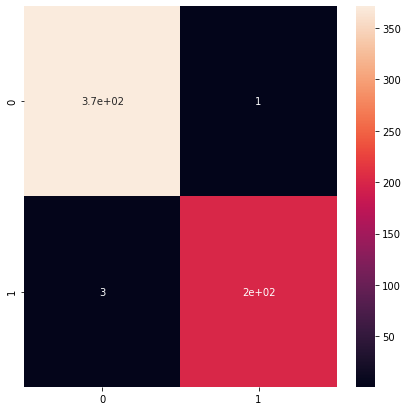

In [ ]:
# Se obtiene la tasa de acierto del modelo
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(original, predict)
plt.figure(figsize=(7, 7))
sns.heatmap(cm, annot=True)

In [ ]:
# Mostrar informe de clasificación
from sklearn.metrics import classification_report
report = classification_report(original, predict, labels = [0,1])
print(report)

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       372
           1       1.00      0.99      0.99       204

   micro avg       0.99      0.99      0.99       576
   macro avg       0.99      0.99      0.99       576
weighted avg       0.99      0.99      0.99       576



/usr/local/lib/python3.7/dist-packages/numpy/lib/arraysetops.py:576: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



# Modelo de Segmentación para encontrar tumor cerebral

In [ ]:
# Se obtiene el dataframe que contiene las resonancias magnéticas que tienen máscaras asociadas
brain_df_mask = brain_df[brain_df['mask'] == 1]
brain_df_mask.shape

(1373, 4)

In [ ]:
# Dividir los datos en train y test
from sklearn.model_selection import train_test_split
X_train, X_val = train_test_split(brain_df_mask, test_size = 0.15)
X_test, X_val = train_test_split(X_val, test_size = 0.5)

In [ ]:
# Se crea una lista separada para image id, class id para pasar nuestro generador
train_ids = list(X_train.image_path)
train_mask = list(X_train.mask_path)
val_ids = list(X_val.image_path)
val_mask = list(X_val.mask_path)

In [ ]:
# Con utilities.py se tiene código para la función de pérdida personalizada y el generador de datos
from utilities import DataGenerator

# Creamos los generadores de las imgs
training_generator = DataGenerator(train_ids, train_mask)
validation_generator = DataGenerator(val_ids, val_mask)

In [ ]:
def resblock(X, f):
  

  # Entrada
  X_copy = X

  # Ruta principal
  X = Conv2D(f, kernel_size = (1,1) ,strides = (1,1),kernel_initializer ='he_normal')(X)
  X = BatchNormalization()(X)
  X = Activation('relu')(X) 

  X = Conv2D(f, kernel_size = (3,3), strides =(1,1), padding = 'same', kernel_initializer ='he_normal')(X)
  X = BatchNormalization()(X)

  # Ruta corta
  X_copy = Conv2D(f, kernel_size = (1,1), strides =(1,1), kernel_initializer ='he_normal')(X_copy)
  X_copy = BatchNormalization()(X_copy)

  # Agregar la salida de la ruta principal y la ruta corta juntas
  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  return X

In [ ]:
# Función para escalar y concatenar los valores pasados
def upsample_concat(x, skip):
  x = UpSampling2D((2,2))(x)
  merge = Concatenate()([x, skip])

  return merge

In [ ]:
input_shape = (256,256,3)

# Forma del tensor de entrada
X_input = Input(input_shape)

# Fase 1
conv1_in = Conv2D(16,3,activation= 'relu', padding = 'same', kernel_initializer ='he_normal')(X_input)
conv1_in = BatchNormalization()(conv1_in)
conv1_in = Conv2D(16,3,activation= 'relu', padding = 'same', kernel_initializer ='he_normal')(conv1_in)
conv1_in = BatchNormalization()(conv1_in)
pool_1 = MaxPool2D(pool_size = (2,2))(conv1_in)

# Fase 2
conv2_in = resblock(pool_1, 32)
pool_2 = MaxPool2D(pool_size = (2,2))(conv2_in)

# Fase 3
conv3_in = resblock(pool_2, 64)
pool_3 = MaxPool2D(pool_size = (2,2))(conv3_in)

# Fase 4
conv4_in = resblock(pool_3, 128)
pool_4 = MaxPool2D(pool_size = (2,2))(conv4_in)

# Fase 5 (Cuello de Botella)
conv5_in = resblock(pool_4, 256)

# Fase de Escalada 1
up_1 = upsample_concat(conv5_in, conv4_in)
up_1 = resblock(up_1, 128)

# Fase de Escalada 2
up_2 = upsample_concat(up_1, conv3_in)
up_2 = resblock(up_2, 64)

# Fase de Escalada 3
up_3 = upsample_concat(up_2, conv2_in)
up_3 = resblock(up_3, 32)

# Fase de Escalada 4
up_4 = upsample_concat(up_3, conv1_in)
up_4 = resblock(up_4, 16)

# Salida Final
output = Conv2D(1, (1,1), padding = "same", activation = "sigmoid")(up_4)

model_seg = Model(inputs = X_input, outputs = output )

In [ ]:
# Ver modelo de segmentación
model_seg.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_59 (Conv2D)              (None, 256, 256, 16) 448         input_9[0][0]                    
__________________________________________________________________________________________________
batch_normalization_58 (BatchNo (None, 256, 256, 16) 64          conv2d_59[0][0]                  
__________________________________________________________________________________________________
conv2d_60 (Conv2D)              (None, 256, 256, 16) 2320        batch_normalization_58[0][0]     
____________________________________________________________________________________________

# Entrenar modelo ResUNet de segmentación y localizar tumor cerebral

In [ ]:
# Desde utilities se obtiene el código para la función de pérdida personalizada
from utilities import focal_tversky, tversky_loss, tversky

In [ ]:
# Compilación del modelo
adam = tf.keras.optimizers.Adam(learning_rate=0.05, epsilon=0.1)
model_seg.compile(optimizer=adam, loss= focal_tversky, metrics=[tversky])

In [ ]:
# Utilizar parada temprana para salir del entrenamiento si ya no se encuentra disminución en loss
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# Guardamos el modelo con menor pérdida de validación
checkpointer = ModelCheckpoint(filepath='ResUNet-weights.hdf5', verbose=1, save_best_only=True)

In [ ]:
history = model_seg.fit(training_generator, epochs=1, validation_data=validation_generator, callbacks=[checkpointer, earlystopping])

72/72 [==============================] - 637s 9s/step - loss: 0.8298 - tversky: 0.2194 - val_loss: 0.8214 - val_tversky: 0.2306

Epoch 00001: val_loss improved from inf to 0.82142, saving model to ResUNet-weights.hdf5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning:

Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.



In [ ]:
# Guardar en JSON la arquitectura del modelo
model_json = model_seg.to_json()
with open('ResUNet-model.json', 'w') as json_file:
  json_file.write(model_json)

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning:

Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.



# Evaluar modelo ResUNet de segmentación

In [ ]:
from utilities import focal_tversky, tversky_loss, tversky
with open('ResUNet-MRI.json', 'r') as json_file:
  json_saveModel = json_file.read()
  
# Cargar el modelo
model_seg = tf.keras.models.model_from_json(json_saveModel)
model_seg.load_weights('weights_seg.hdf5')
adam = tf.keras.optimizers.Adam(learning_rate=0.05, epsilon=0.1)
model_seg.compile(optimizer=adam, loss=focal_tversky, metrics=[tversky])

In [ ]:
from utilities import prediction
# Hacemos la predicción
image_id, mask, has_mask = prediction(test, model, model_seg)

In [ ]:
# Creamos el dataframe para el resultado
df_pred = pd.DataFrame({'image_path':image_id, 'predicted_mask':mask,'has_mask':has_mask})
df_pred

image_path  ... has_mask
0    TCGA_DU_7013_19860523/TCGA_DU_7013_19860523_49...  ...        0
1    TCGA_CS_6665_20010817/TCGA_CS_6665_20010817_15...  ...        1
2    TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_7.tif  ...        0
3    TCGA_FG_A4MU_20030903/TCGA_FG_A4MU_20030903_26...  ...        1
4    TCGA_DU_6408_19860521/TCGA_DU_6408_19860521_4.tif  ...        0
..                                                 ...  ...      ...
585  TCGA_DU_6408_19860521/TCGA_DU_6408_19860521_2.tif  ...        0
586  TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_49...  ...        1
587  TCGA_HT_7693_19950520/TCGA_HT_7693_19950520_17...  ...        1
588  TCGA_DU_7294_19890104/TCGA_DU_7294_19890104_10...  ...        0
589  TCGA_DU_7294_19890104/TCGA_DU_7294_19890104_21...  ...        1

[590 rows x 3 columns]

In [ ]:
# Fusionar el data frame que contiene los resultados previstos con los datos de prueba originales (Comparativa)
df_pred = test.merge(df_pred, on='image_path')
df_pred.head()

image_path  ... has_mask
0  TCGA_DU_7013_19860523/TCGA_DU_7013_19860523_49...  ...        0
1  TCGA_CS_6665_20010817/TCGA_CS_6665_20010817_15...  ...        1
2  TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_7.tif  ...        0
3  TCGA_FG_A4MU_20030903/TCGA_FG_A4MU_20030903_26...  ...        1
4  TCGA_DU_6408_19860521/TCGA_DU_6408_19860521_4.tif  ...        0

[5 rows x 5 columns]

# Resultados

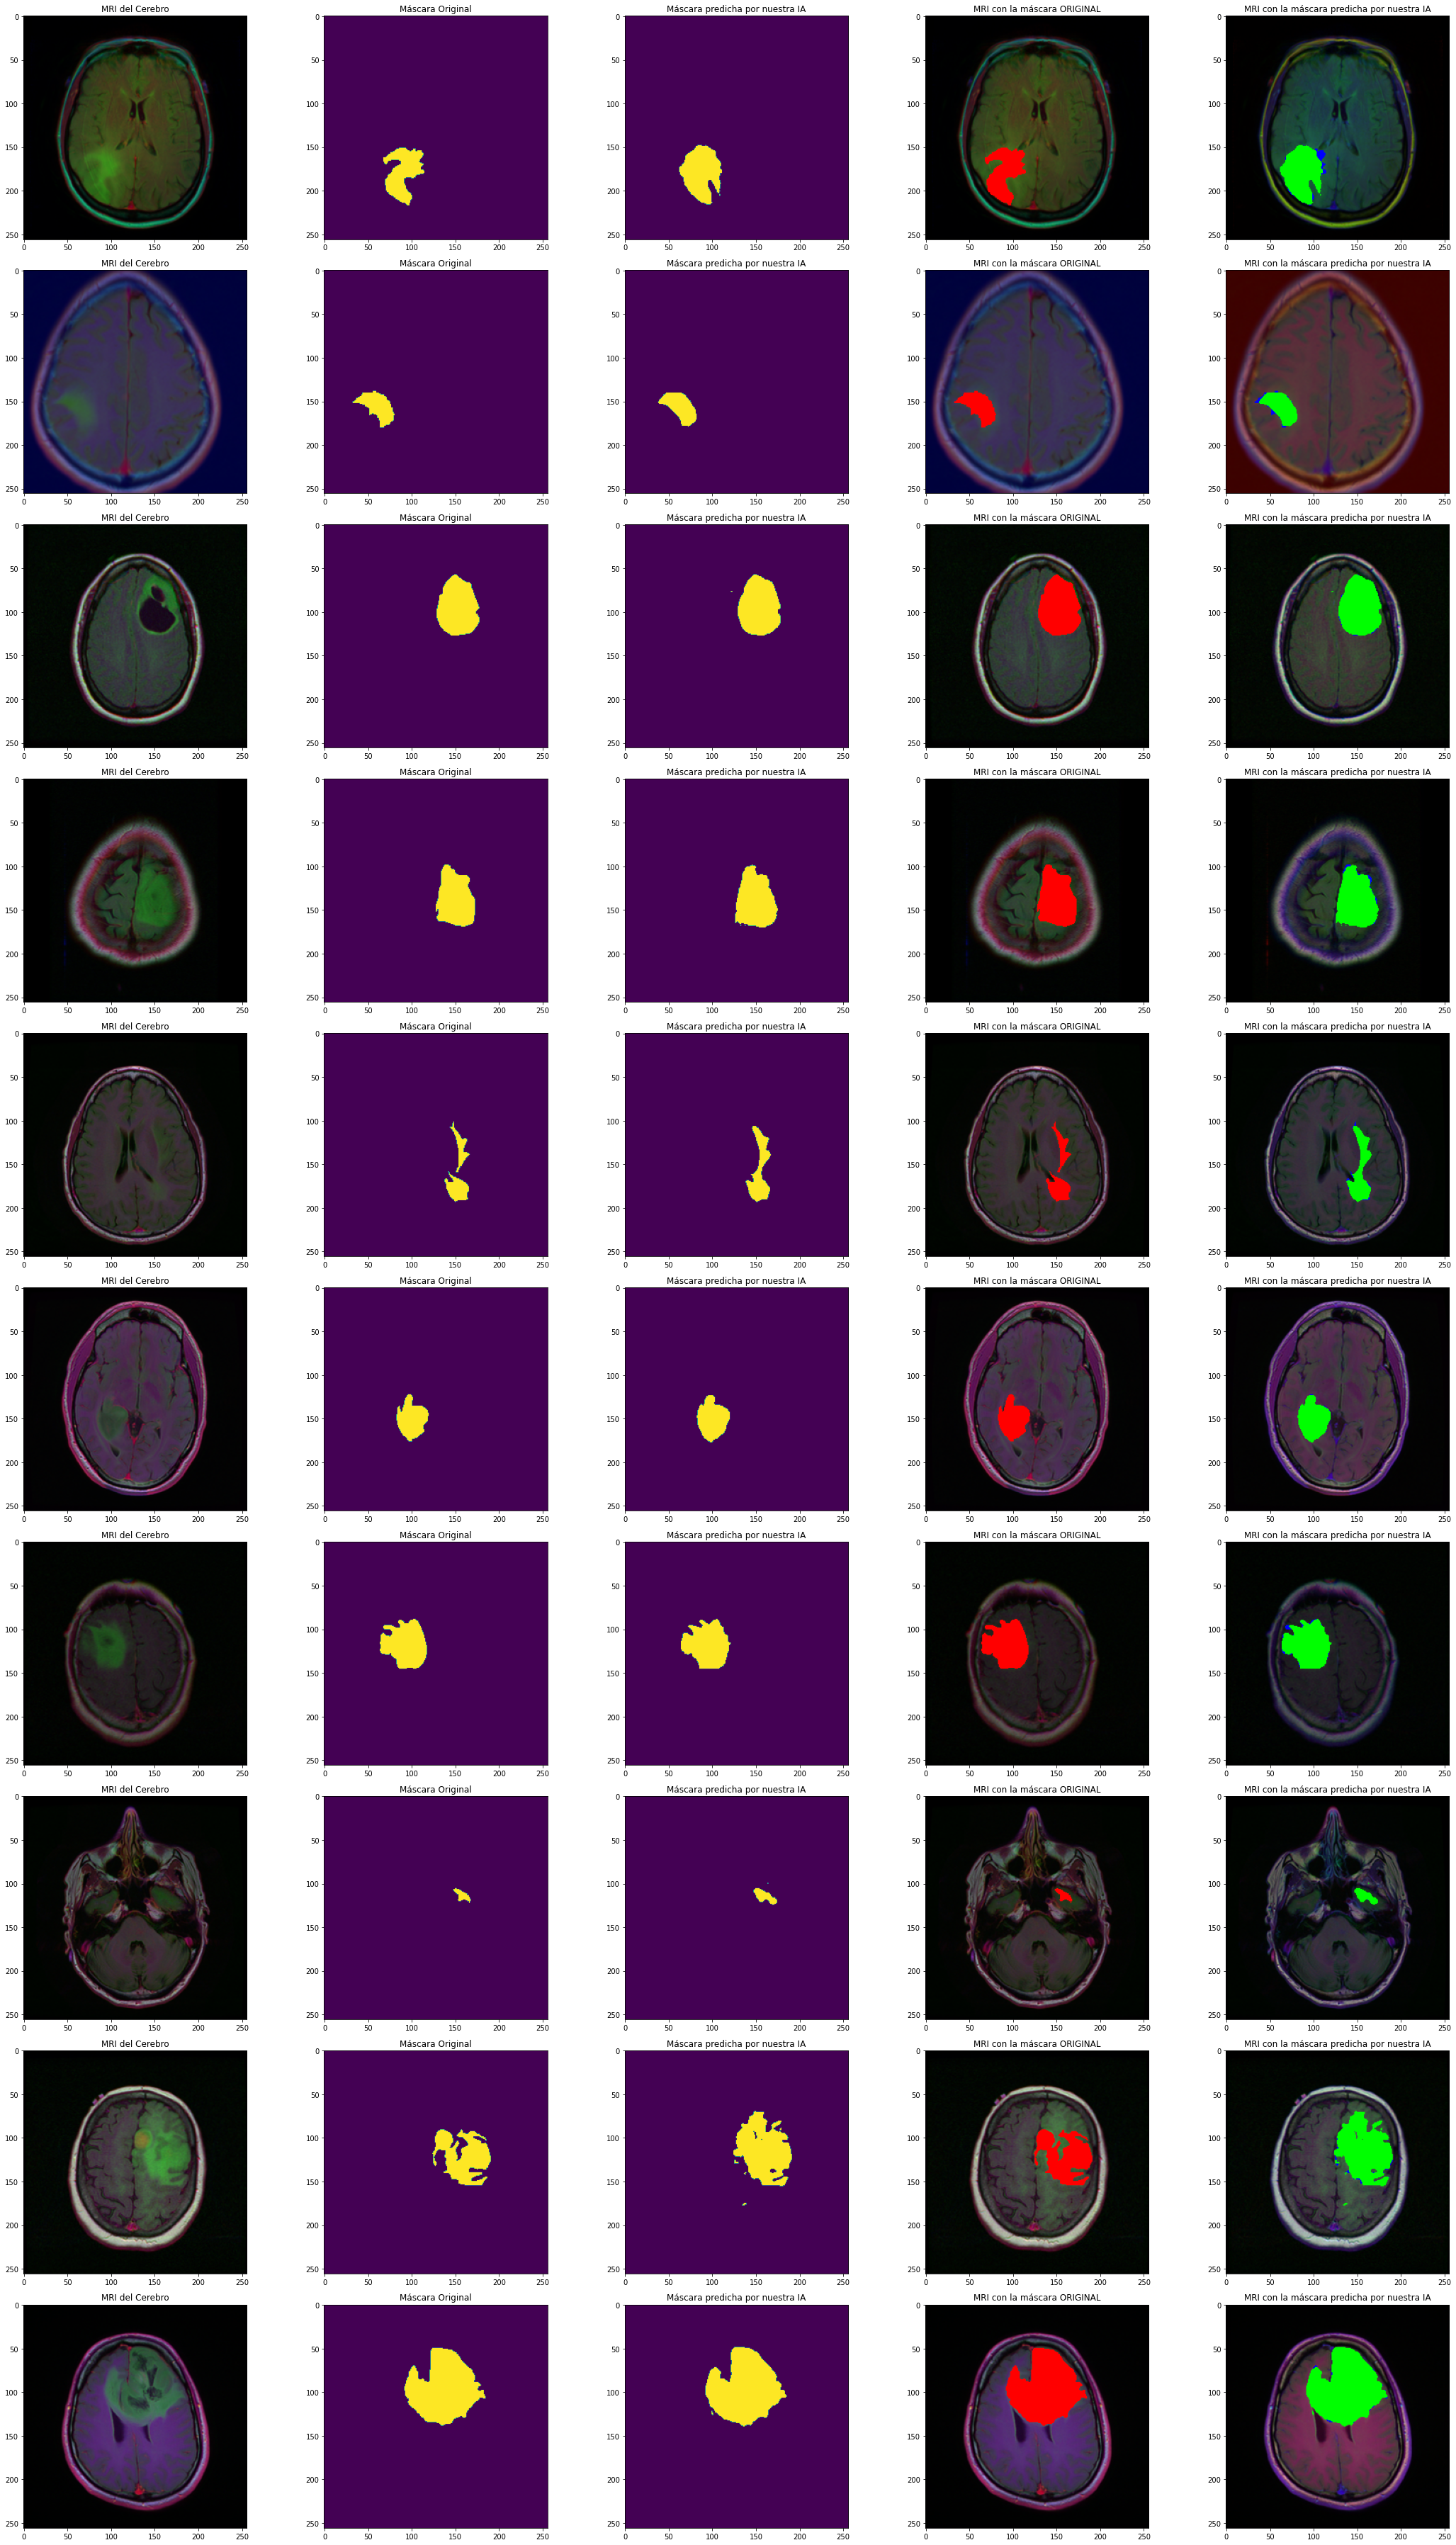

In [ ]:
count = 0
fig, axs = plt.subplots(10, 5, figsize = (30, 50))
for i in range(len(df_pred)):
  if df_pred['has_mask'][i] == 1 and count < 10:
    # Leer las imgs y convertirlas a RGB
    img = io.imread(df_pred.image_path[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axs[count][0].title.set_text('MRI del Cerebro')
    axs[count][0].imshow(img)

    # Obtener la máscara para la imagen
    mask = io.imread(df_pred.mask_path[i])
    axs[count][1].title.set_text('Máscara Original')
    axs[count][1].imshow(mask)

    # Obtenemos la máscara de predicción de dicha img
    predicted_mask = np.asarray(df_pred.predicted_mask[i])[0].squeeze().round()
    axs[count][2].title.set_text('Máscara predicha por nuestra IA')
    axs[count][2].imshow(predicted_mask)

    # Aplicamos la máscara a la img
    img[mask == 255] = (255, 0 , 0)
    axs[count][3].title.set_text('MRI con la máscara ORIGINAL')
    axs[count][3].imshow(img)


    img_ = io.imread(df_pred.image_path[i])
    img_ = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_[predicted_mask == 1] = (0, 255, 0)
    axs[count][4].title.set_text('MRI con la máscara predicha por nuestra IA')
    axs[count][4].imshow(img_)
    count += 1

fig.tight_layout()
